In [1]:
import os
import h5py
from PIL import Image
%pylab inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [30]:
def get_attrs(digit_struct_mat_file, index):
    """
    Returns a dictionary which contains keys: label, left, top, width and height, each key has multiple values.
    """
    attrs = {}
    f = digit_struct_mat_file
    item = f['digitStruct2']['bbox'][index].item()
    for key in ['label', 'left', 'top', 'width', 'height']:
        attr = f[item][key]
        values = [f[attr.value[i].item()].value[0][0]
                  for i in range(len(attr))] if len(attr) > 1 else [attr.value[0][0]]
        attrs[key] = values
    return attrs

In [22]:
path_to_dir = '/mnt/c/Users/zding/Pictures/spartan/data/test'
path_to_digit_struct_mat_file = os.path.join(path_to_dir, 'digitStruct2.mat')

In [19]:
path_to_image_file = os.path.join(path_to_dir, '2.png')
index = int(path_to_image_file.split('/')[-1].split('.')[0]) - 1
print ('index %d: %s' % (index, path_to_image_file))

index 1: /mnt/c/Users/zding/Pictures/spartan/data/test/2.png


In [25]:
f = h5py.File(path_to_digit_struct_mat_file, 'r')

In [31]:
with h5py.File(path_to_digit_struct_mat_file, 'r') as digit_struct_mat_file:
    attrs = get_attrs(digit_struct_mat_file, index)
    length = len(attrs['label'])
    attrs_left, attrs_top, attrs_width, attrs_height = map(lambda x: [int(i) for i in x],
                                                       [attrs['left'], attrs['top'], attrs['width'], attrs['height']])
    min_left, min_top, max_right, max_bottom = (min(attrs_left),
                                                min(attrs_top),
                                                max(map(lambda x, y: x + y, attrs_left, attrs_width)),
                                                max(map(lambda x, y: x + y, attrs_top, attrs_height)))
    center_x, center_y, max_side = ((min_left + max_right) / 2.0,
                                    (min_top + max_bottom) / 2.0,
                                    max(max_right - min_left, max_bottom - min_top))
    bbox_left, bbox_top, bbox_width, bbox_height = (center_x - max_side / 2.0, 
                                                    center_y - max_side / 2.0, 
                                                    max_side,
                                                    max_side)
    cropped_left, cropped_top, cropped_width, cropped_height = (int(round(bbox_left - 0.15 * bbox_width)),
                                                                int(round(bbox_top - 0.15 * bbox_height)),
                                                                int(round(bbox_width * 1.3)),
                                                                int(round(bbox_height * 1.3)))
print ('min_left=%d, min_top=%d, max_right=%d, max_bottom=%d' % (min_left, min_top, max_right, max_bottom))
print ('center_x=%.1f, center_y=%.1f, max_side=%d' % (center_x, center_y, max_side))
print ('bbox: left=%.1f, top=%.1f, width=%d, height=%d' % (bbox_left, bbox_top, bbox_width, bbox_height))
print ('cropped: left=%d, top=%d, width=%d, height=%d' % (cropped_left, cropped_top, cropped_width, cropped_height))

min_left=99, min_top=5, max_right=133, max_bottom=31
center_x=116.0, center_y=18.0, max_side=34
bbox: left=99.0, top=1.0, width=34, height=34
cropped: left=94, top=-4, width=44, height=44


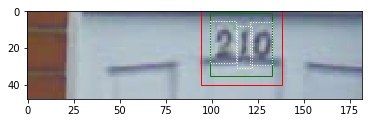

In [32]:
image = Image.open(path_to_image_file)
plt.figure()
currentAxis = plt.gca()
currentAxis.imshow(image)
currentAxis.add_patch(Rectangle((cropped_left, cropped_top), cropped_width, cropped_height, fill=False, edgecolor='red'))
currentAxis.add_patch(Rectangle((bbox_left, bbox_top), bbox_width, bbox_height, fill=False, edgecolor='green'))
for attr_left, attr_top, attr_width, attr_height in zip(attrs_left, attrs_top, attrs_width, attrs_height):
    currentAxis.add_patch(Rectangle((attr_left, attr_top), attr_width, attr_height, fill=False, edgecolor='white', linestyle='dotted'))
plt.show()

In [ ]:
import os
import argparse
import json
parser = argparse.ArgumentParser(description="Tool that loads model and predicts on a given image")
args = parser.parse_args()
import chainer
import chainer.functions as F
from PIL import Image
def load_image(image_file, xp):
    with Image.open(image_file) as the_image:
        image = xp.asarray(the_image, dtype=np.float32)
        image /= 255
        image = image.transpose(2, 0, 1)
    #
        return image
args.is_original_fsns = True
args.log_name = 'log'
args.dropout_ratio = 0.5
args.blank_symbol = 0
# max number of text regions in the image
args.timesteps = 4
# max number of characters per word
args.num_labels = 21
args.model_dir = '/home/ubuntu/zk/see/datasets/models/'
# open log and extract meta information
with open(os.path.join(args.model_dir, args.log_name)) as the_log:
    log_data = json.load(the_log)[0]

target_shape = Size._make(log_data['target_size'])
image_size = Size._make(log_data['image_size'])
args.gpu = -1
xp = chainer.cuda.cupy if args.gpu >= 0 else np
network = create_network(args, log_data)
args.snapshot_name = 'model_35000.npz'
# load weights
with np.load(os.path.join(args.model_dir, args.snapshot_name)) as f:
    chainer.serializers.NpzDeserializer(f).load(network)
args.char_map = '/home/ubuntu/zk/see/datasets/svhn/svhn_char_map.json'
# load char map
with open(args.char_map) as the_map:
    char_map = json.load(the_map)
args.image_path = '/home/ubuntu/zk/see/datasets/testimg/4.png'
# load image
image = load_image(args.image_path, xp)
with configuration.using_config('train', False):
    predictions, crops, grids = network(image[xp.newaxis, ...])